In [1]:
import json
import os
import pandas as pd
import numpy as np
import pickle as pkl

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
SHAP_DIR = os.path.join(PROJECT_DIR, 'classification/shap_values/coqa/')
MASK_DIR = os.path.join(SHAP_DIR, 'masktoken_mask_default')

In [2]:
roberta_stats_token = 'agg-sv_roberta_overall-avg_token_test.json'
roberta_stats_3gram = 'agg-sv_roberta_overall-avg_3gram_test.json'
roberta_stats_5gram = 'agg-sv_roberta_overall-avg_5gram_test.json'

bert_stats_token = 'agg-sv_bert_overall-avg_token_test.json'
bert_stats_3gram = 'agg-sv_bert_overall-avg_3gram_test.json'
bert_stats_5gram = 'agg-sv_bert_overall-avg_5gram_test.json'

distilbert_stats_token = 'agg-sv_distilbert_overall-avg_token_test.json'
distilbert_stats_3gram = 'agg-sv_distilbert_overall-avg_3gram_test.json'
distilbert_stats_5gram = 'agg-sv_distilbert_overall-avg_5gram_test.json'

bert_large_stats_token = 'agg-sv_bert-large_overall-avg_token_test.json'
bert_large_stats_3gram = 'agg-sv_bert-large_overall-avg_3gram_test.json'
bert_large_stats_5gram = 'agg-sv_bert-large_overall-avg_5gram_test.json'

deberta_stats_token = 'agg-sv_deberta_overall-avg_token_test.json'
deberta_stats_3gram = 'agg-sv_deberta_overall-avg_3gram_test.json'
deberta_stats_5gram = 'agg-sv_deberta_overall-avg_5gram_test.json'

roberta_freq = json.load(open(os.path.join(SHAP_DIR, 'roberta_entity_frequency_test_empty.json'), 'r'))
bert_freq = json.load(open(os.path.join(SHAP_DIR, 'bert_entity_frequency_test_empty.json'), 'r'))
distilbert_freq = json.load(open(os.path.join(SHAP_DIR, 'distilbert_entity_frequency_test_empty.json'), 'r'))
bert_large_freq = json.load(open(os.path.join(SHAP_DIR, 'bert-large_entity_frequency_test_empty.json'), 'r'))
deberta_freq = json.load(open(os.path.join(SHAP_DIR, 'deberta_entity_frequency_test_empty.json'), 'r'))

entity_frequency_dict_mask = None

In [8]:
def visualize_shap_results(shap_file, n_features=10, freq_dict=None):

    #freq_dict = entity_frequency_dict
    load_from_dir = SHAP_DIR
    entity_type = shap_file.split('_')[3]+'s'

    # Relevant for chunk-level shap values
    # Using different mask tokens leads to different chunks
    # + values derived with mask_token==[MASK] are in a different DIR
    if 'mask' in shap_file:
        freq_dict = entity_frequency_dict_mask
        load_from_dir = MASK_DIR

    if 'class-avg' in shap_file:
        with open(os.path.join(load_from_dir, shap_file), 'r') as f:
            shap_results = json.load(f)

        # Get frequency info and filter out tokens with frequency < 10
        sorted_neg = [
            (k, v) for k, v in sorted(shap_results.items(), key=lambda item: item[1][0])
            if freq_dict[entity_type][k] >= 20
        ]
        top_n_neg = sorted_neg[:n_features]
        neg_df = pd.DataFrame(top_n_neg, columns=['token', 'shap_values'])
        neg_df['shap_neg'] = neg_df['shap_values'].apply(lambda x: float(x[0]))
        neg_df['shap_pos'] = neg_df['shap_values'].apply(lambda x: float(x[1]))
        neg_df = neg_df.drop(columns=['shap_values'])
        
        sorted_pos = [
            (k, v) for k, v in sorted(shap_results.items(), key=lambda item: item[1][1])
            if freq_dict[entity_type][k] >= 20
        ]
        top_n_pos = sorted_pos[-n_features:]
        pos_df = pd.DataFrame(top_n_pos, columns=['token', 'shap_values'])
        pos_df['shap_neg'] = pos_df['shap_values'].apply(lambda x: float(x[0]))
        pos_df['shap_pos'] = pos_df['shap_values'].apply(lambda x: float(x[1]))
        pos_df = pos_df.drop(columns=['shap_values'])

        top_shap_values = pd.merge(neg_df, pos_df, how='outer')

        # add frequency info: add to name of token
        top_shap_values['token'] = top_shap_values['token'].apply(
            lambda x: x + f" ({freq_dict[entity_type][x]})"
        )

        top_shap_values.plot(x='token', y=['shap_neg', 'shap_pos'], kind='barh', figsize=(20, 10))
        
    else:
        with open(os.path.join(load_from_dir, shap_file), 'r') as f:
            shap_results = json.load(f)
        
        sorted_shap_results = {
            k: v for k, v in sorted(shap_results.items(), key=lambda item: item[1])
        }
        
        shap_df = pd.DataFrame(sorted_shap_results.items(), columns=['token', 'shap_value'])

        # add frequency column
        shap_df['frequency'] = shap_df['token'].apply(
            lambda x: freq_dict[entity_type][x]
        )
        # filter out tokens with frequency < 10
        shap_df = shap_df[shap_df['frequency'] >= 20]

        top_n_neg = shap_df.head(n_features)
        top_n_pos = shap_df.tail(n_features)
        top_shap_values = pd.merge(top_n_neg, top_n_pos, how='outer')

        # add frequency to name of token
        top_shap_values['token'] = top_shap_values['token'].apply(
            lambda x: x + f" ({freq_dict[entity_type][x]})"
        )
    
        top_shap_values.plot(x='token', y='shap_value', kind='barh', figsize=(20, 10))

    return top_shap_values

## Token-level

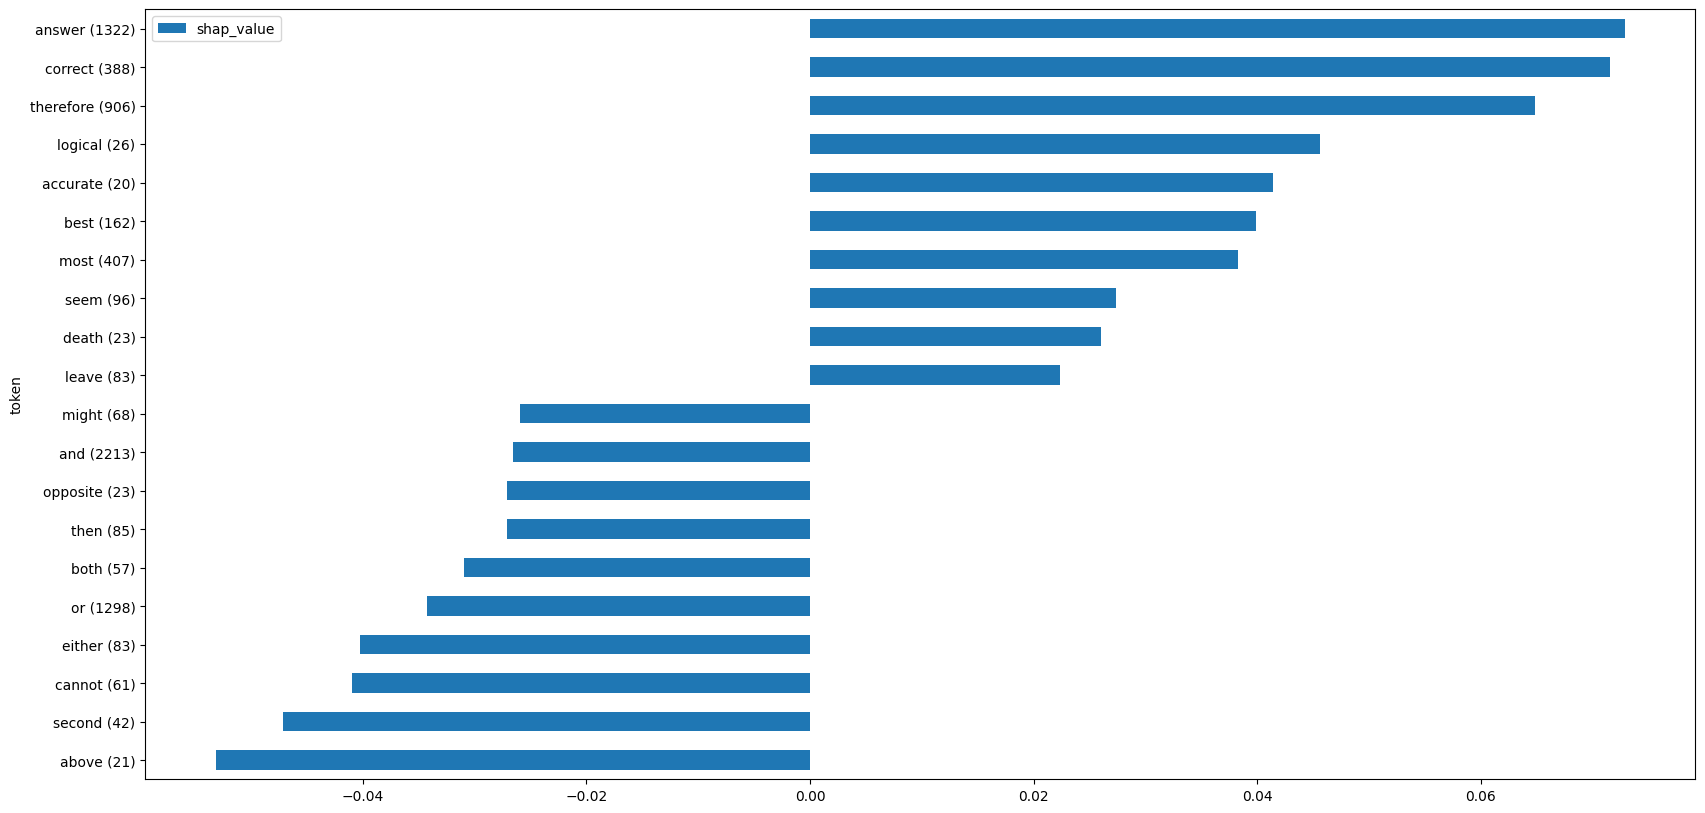

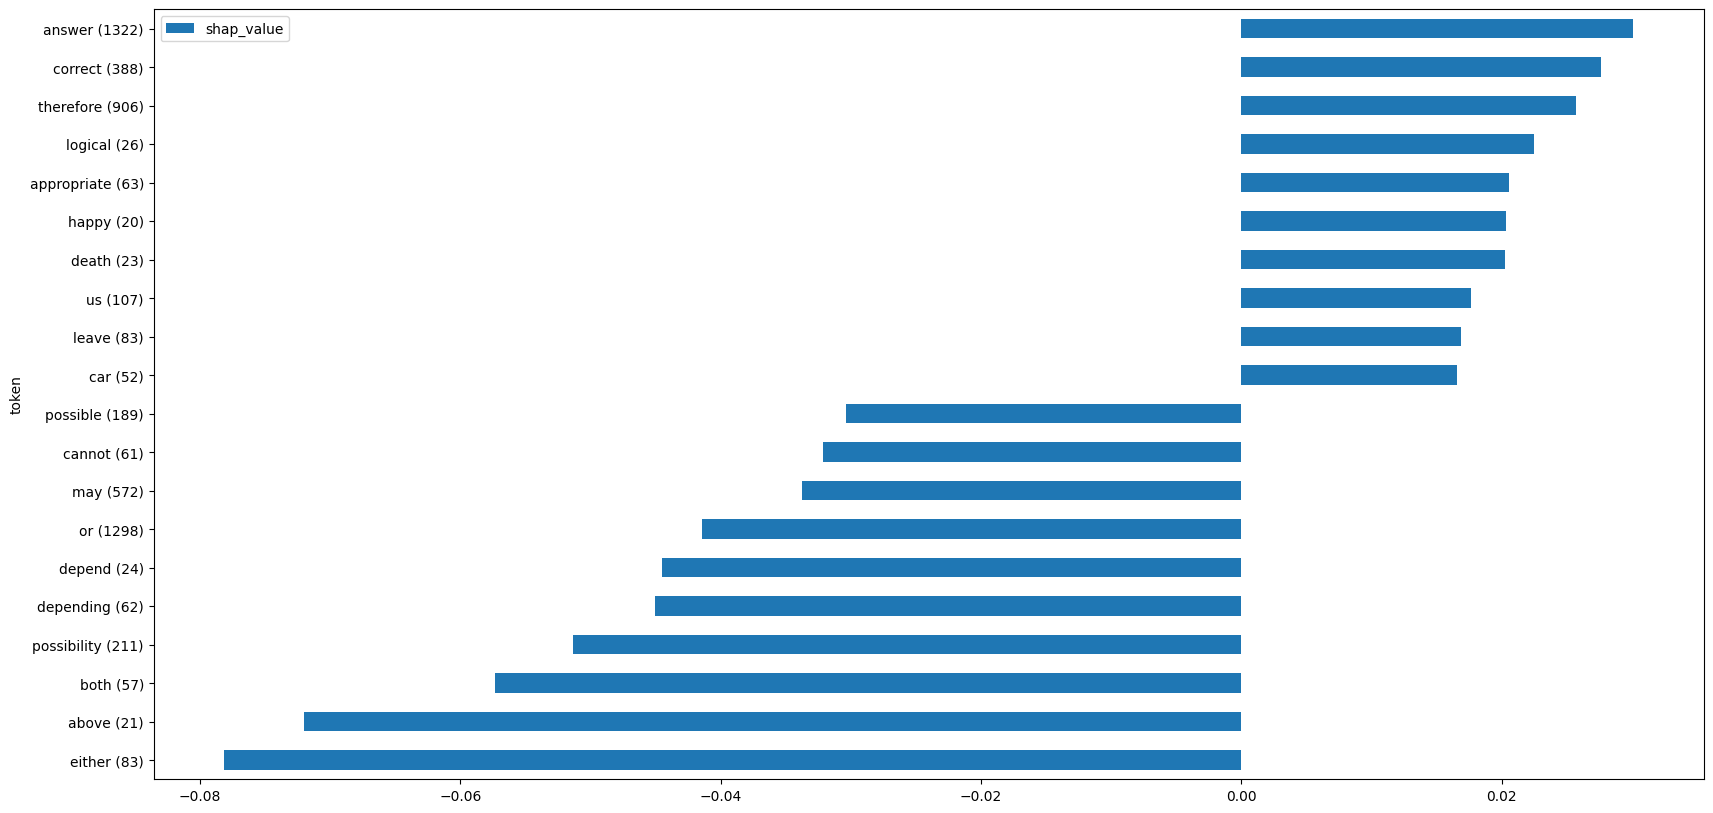

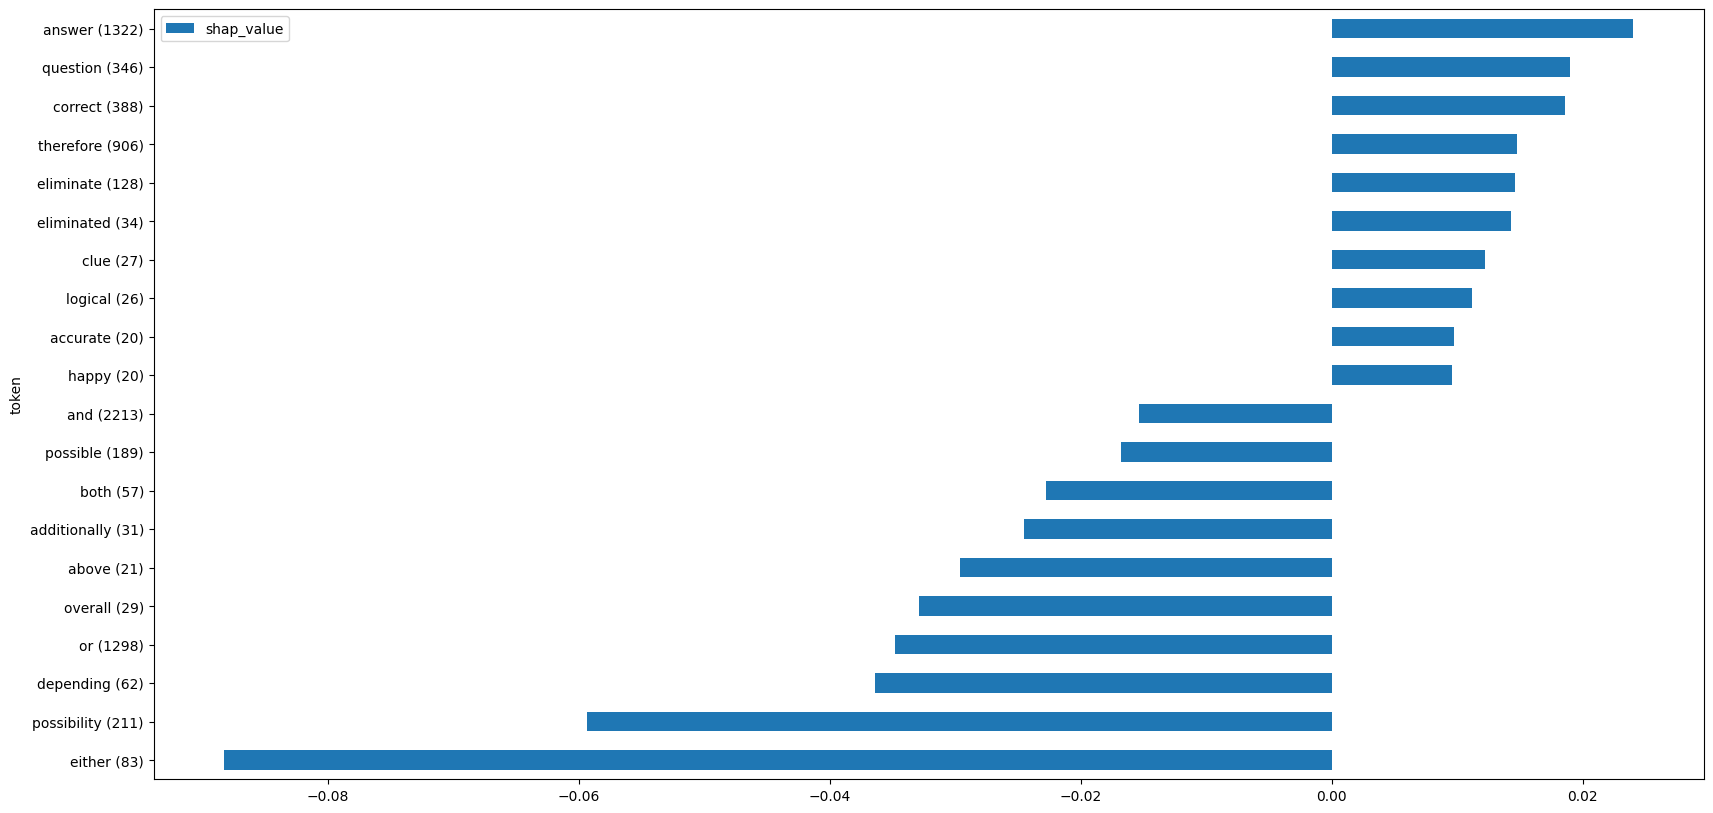

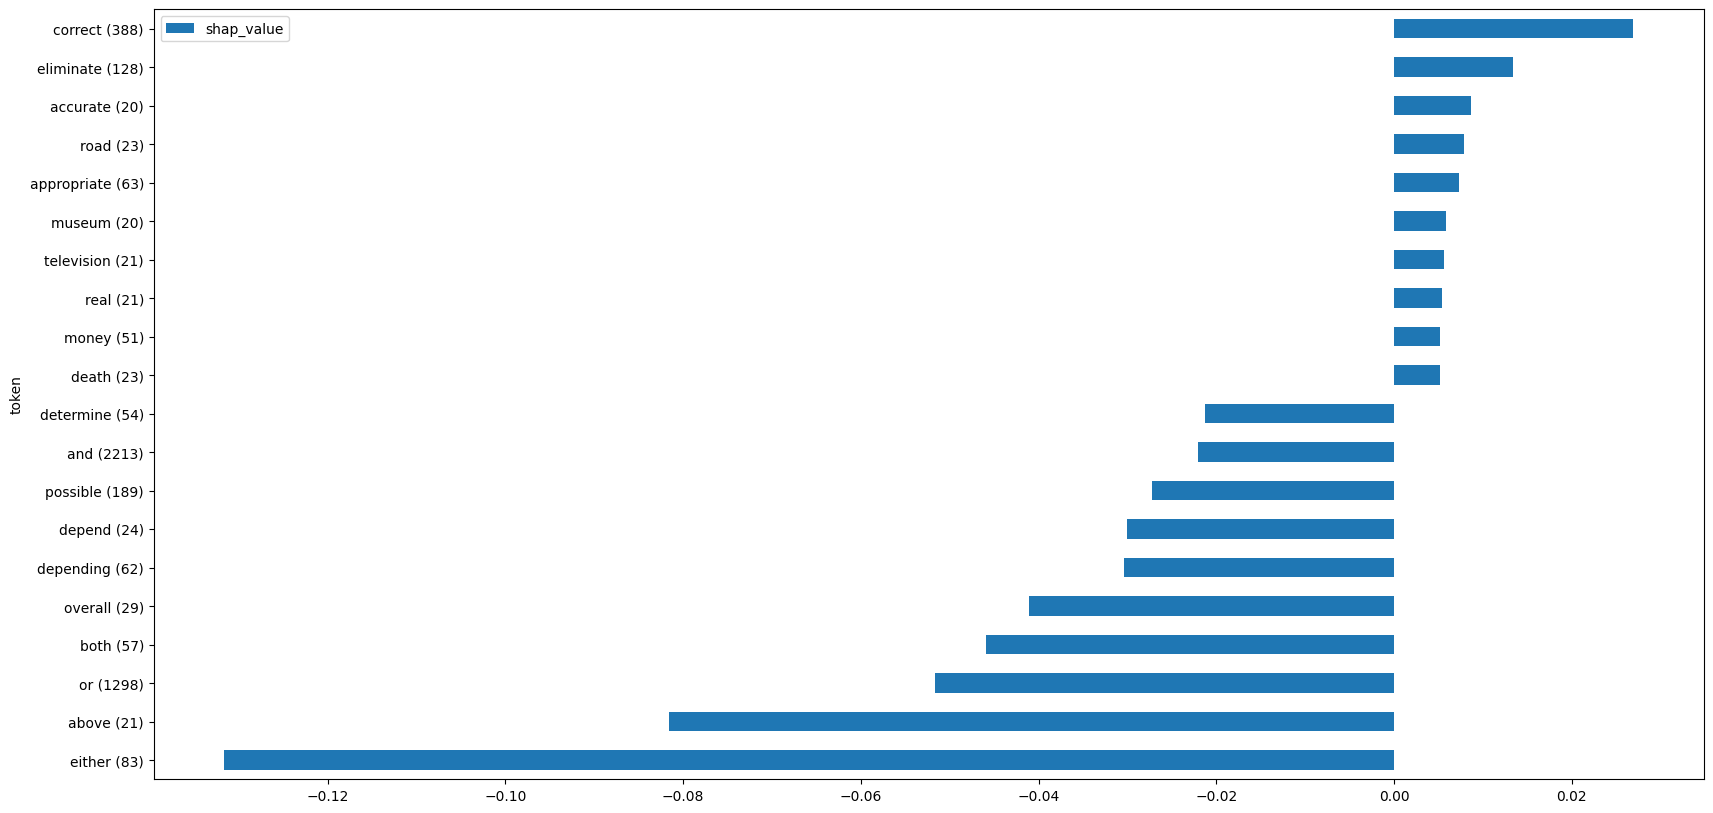

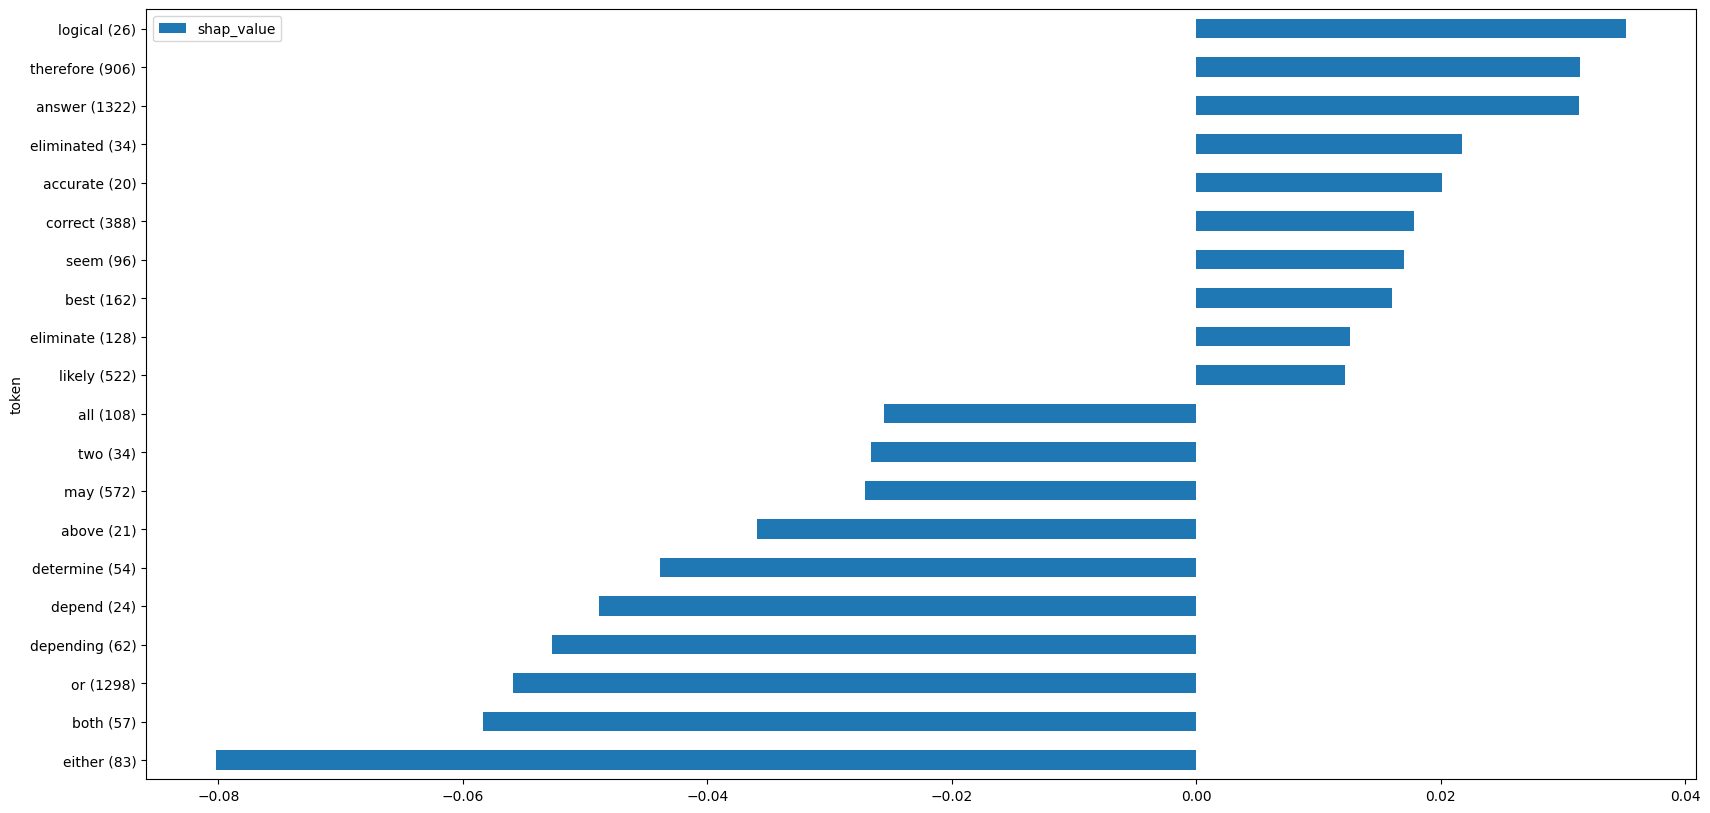

In [9]:
roberta_top_tokens = visualize_shap_results(roberta_stats_token, n_features=10, freq_dict=roberta_freq)
bert_top_tokens = visualize_shap_results(bert_stats_token, n_features=10, freq_dict=bert_freq)
distilbert_top_tokens = visualize_shap_results(distilbert_stats_token, n_features=10, freq_dict=distilbert_freq)
bert_large_top_tokens = visualize_shap_results(bert_large_stats_token, n_features=10, freq_dict=bert_large_freq)
deberta_top_tokens = visualize_shap_results(deberta_stats_token, n_features=10, freq_dict=deberta_freq)

In [12]:
roberta_top_tokens

,token,shap_value,frequency
0,above (21),-0.05315,21
1,second (42),-0.04709,42
2,cannot (61),-0.04093,61
3,either (83),-0.04021,83
4,or (1298),-0.03427,1298
5,both (57),-0.03098,57
6,then (85),-0.02714,85
7,opposite (23),-0.02706,23
8,and (2213),-0.02657,2213
9,might (68),-0.02595,68


In [11]:
top_tokens = pd.DataFrame()
top_tokens['roberta'] = roberta_top_tokens['token']
top_tokens['bert'] = bert_top_tokens['token']
top_tokens['distilbert'] = distilbert_top_tokens['token']
top_tokens['bert-large'] = bert_large_top_tokens['token']
top_tokens['deberta'] = deberta_top_tokens['token']

top_tokens

,roberta,bert,distilbert,bert-large,deberta
0,above (21),either (83),either (83),either (83),either (83)
1,second (42),above (21),possibility (211),above (21),both (57)
2,cannot (61),both (57),depending (62),or (1298),or (1298)
3,either (83),possibility (211),or (1298),both (57),depending (62)
4,or (1298),depending (62),overall (29),overall (29),depend (24)
5,both (57),depend (24),above (21),depending (62),determine (54)
6,then (85),or (1298),additionally (31),depend (24),above (21)
7,opposite (23),may (572),both (57),possible (189),may (572)
8,and (2213),cannot (61),possible (189),and (2213),two (34)
9,might (68),possible (189),and (2213),determine (54),all (108)


In [14]:
top_neg_tokens = top_tokens.head(10)
top_neg_tokens

,roberta,bert,distilbert,bert-large,deberta
0,above (21),either (83),either (83),either (83),either (83)
1,second (42),above (21),possibility (211),above (21),both (57)
2,cannot (61),both (57),depending (62),or (1298),or (1298)
3,either (83),possibility (211),or (1298),both (57),depending (62)
4,or (1298),depending (62),overall (29),overall (29),depend (24)
5,both (57),depend (24),above (21),depending (62),determine (54)
6,then (85),or (1298),additionally (31),depend (24),above (21)
7,opposite (23),may (572),both (57),possible (189),may (572)
8,and (2213),cannot (61),possible (189),and (2213),two (34)
9,might (68),possible (189),and (2213),determine (54),all (108)


In [23]:
# for each possible value in top_neg_tokens, count how many times it appears across all columns
top_neg_tokens.apply(pd.value_counts).fillna(0).sum(axis=1).sort_values(ascending=False)

5                    10.0
both (57)             5.0
or (1298)             5.0
either (83)           5.0
above (21)            5.0
depending (62)        4.0
depend (24)           3.0
and (2213)            3.0
possible (189)        3.0
cannot (61)           2.0
determine (54)        2.0
overall (29)          2.0
possibility (211)     2.0
may (572)             2.0
additionally (31)     1.0
might (68)            1.0
opposite (23)         1.0
all (108)             1.0
second (42)           1.0
then (85)             1.0
two (34)              1.0
dtype: float64

In [27]:
def calculate_weighted_ranking(df, num_features=10):
    ranking = {}
    for col in df.columns:
        for i, token in enumerate(df[col]):
            if token not in ranking:
                ranking[token] = 0
            ranking[token] += num_features - i

    del ranking[5]

    # sort by value
    ranking = {
        k: v for k, v in sorted(ranking.items(), key=lambda item: item[1], reverse=True)
    }
    return ranking

calculate_weighted_ranking(top_neg_tokens)

{'either (83)': 47,
 'above (21)': 37,
 'or (1298)': 33,
 'both (57)': 32,
 'depending (62)': 26,
 'possibility (211)': 16,
 'depend (24)': 15,
 'overall (29)': 12,
 'cannot (61)': 10,
 'second (42)': 9,
 'may (572)': 6,
 'possible (189)': 6,
 'determine (54)': 6,
 'and (2213)': 5,
 'then (85)': 4,
 'additionally (31)': 4,
 'opposite (23)': 3,
 'two (34)': 2,
 'might (68)': 1,
 'all (108)': 1}